tensor([[-9999., -9999., -9999.,  ..., -9999., -9999., -9999.],
        [-9999.,    60.,    40.,  ...,    40.,    50., -9999.],
        [-9999.,    60.,    10.,  ...,    10.,    50., -9999.],
        ...,
        [-9999.,    60.,    10.,  ...,    10.,    50., -9999.],
        [-9999.,    60.,    40.,  ...,    40.,    50., -9999.],
        [-9999., -9999., -9999.,  ..., -9999., -9999., -9999.]],
       device='cuda:0')
torch.Size([5, 5625])


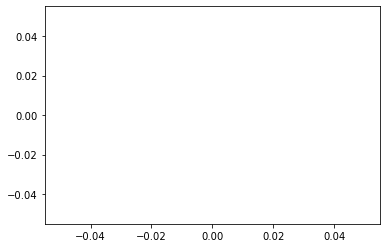

/home/lunet/cvxt2/.conda/envs/torch_hipims/lib/python3.7/site-packages/ipykernel_launcher.py:152: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


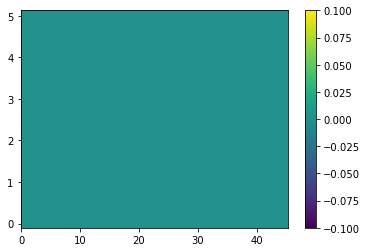

In [3]:
from numpy.lib.npyio import savetxt
import torch
import math
import sys
import os
import numpy as np
import time
import matplotlib.pyplot as plt

from SWE_CUDA import Godunov

cell_size = 0.2012
paraDict = {'deviceID': 0,
            'dx': float(cell_size),
            'CFL': 0.5,
            'Export_timeStep': 100,
            't': 0.0,
            'export_n': 0,
            'secondOrder': True,
            'firstTimeStep': 0.001,
            'tensorType': torch.float64,
            'EndTime': 100,
        }

OUTPUT_PATH = '/home/lunet/cvxt2/hipims_hybrid-master/BackCase'

# ===============================================
# set the device
# ===============================================
torch.cuda.set_device(paraDict['deviceID'])
device = torch.device("cuda", paraDict['deviceID'])

# ===============================================
# set the tensors
# ===============================================

# prepare the dem
tensorsize = [25+2, 225+2]

z = torch.zeros(tensorsize, device=device)
h = torch.zeros(tensorsize, device=device)
qx = torch.zeros(tensorsize, device=device) 
qy = torch.zeros(tensorsize, device=device)
wl = torch.zeros(tensorsize, device=device)
wl = z + h

# set mask
mask = torch.ones(tensorsize, device=device) * 10

# wall non-slip
mask[1,:] = 40
mask[-2,:] = 40
# mask[10, 1:500] = 30
# mask[10:25, 500] = 30
# upstream and downstream
mask[:,1] = 60
mask[:,-2] = 50

# mask[11:26, 1:500] = -9999

# outline
mask[0,:] = -9999
mask[-1,:] = -9999
mask[:,0] = -9999
mask[:,-1] = -9999
print(mask)

rainfall_station_Mask = torch.zeros(tensorsize, device=device)

row = torch.arange(tensorsize[0])
col = torch.arange(tensorsize[1])
y, x = torch.meshgrid(row, col)
x, y = x.type(torch.DoubleTensor), y.type(torch.DoubleTensor)
x = (x - 0.5) * cell_size
y = (y - 0.5) * cell_size
x = x.numpy()
y = y.numpy()

landuse = torch.zeros(tensorsize, device=device)
Manning = 0.01

# ===============================================
# rainfall data
# ===============================================

gauge_index_1D = torch.tensor([])

gauge_index_1D = gauge_index_1D.to(device)

rainfallMatrix = np.array([[0., 0.0], [200., 0.0]])

# ===============================================
# H_GIVEN & Q_GIVEN data
# ===============================================
given_depth = torch.tensor([[0.0, 0.242], [600, 0.242]], dtype=torch.float64, device=device)
given_discharge = torch.tensor([[0.0, 0.202, 0.0], [600, 0.202, 0.0]], dtype=torch.float64, device=device)

# ===============================================
# set field data
# ===============================================
numerical = Godunov(device,
                    paraDict['dx'],
                    paraDict['CFL'],
                    paraDict['Export_timeStep'],
                    t=paraDict['t'],
                    export_n=paraDict['export_n'],
                    firstTimeStep=paraDict['firstTimeStep'],
                    secondOrder=paraDict['secondOrder'],
                    tensorType=paraDict['tensorType'])

numerical.setOutPutPath(OUTPUT_PATH)
numerical.init__fluidField_tensor(mask, h, qx, qy, wl, z, device)
numerical.set__frictionField_tensor(Manning, device)
numerical.set_boundary_tensor(given_depth, given_discharge)
numerical.set_landuse(mask, landuse, device)

# ======================================================================
numerical.set_distributed_rainfall_station_Mask(mask, rainfall_station_Mask,
                                                    device)
# ======================================================================

torch.cuda.empty_cache()

simulation_start = time.time()

index_mask = torch.zeros_like(mask, dtype=torch.int32,
                                      device=device)
index_mask = torch.tensor(
    [i for i in range((mask.flatten()).size()[0])],
    dtype=torch.int32,
    device=device,
)

hh = torch.zeros(tensorsize, dtype=torch.float64, device=device) 
qxx = torch.zeros(tensorsize, dtype=torch.float64, device=device) 
qyy = torch.zeros(tensorsize, dtype=torch.float64, device=device) 

while numerical.t.item() < 8:
    numerical.addFlux()
    numerical.addStation_PrecipitationSource(rainfallMatrix, device)
    numerical.time_friction_euler_update_cuda(device)
    
hh[mask>0] = numerical.get_h()
qxx[mask>0] = numerical.get_qx()
qyy[mask>0] = numerical.get_qy()

q_x = qxx.cpu().numpy()
q_y = qyy.cpu().numpy()
plt.streamplot(x, y, q_x, q_y, density = 0.5)
plt.show()

plt.pcolor(x, y, hh.cpu().numpy())
plt.colorbar()
plt.show()


tensor([[-9999., -9999., -9999.,  ..., -9999., -9999., -9999.],
        [-9999.,    60.,    30.,  ...,    30.,    50., -9999.],
        [-9999.,    60.,    10.,  ...,    10.,    50., -9999.],
        ...,
        [-9999.,    60.,    10.,  ...,    10.,    50., -9999.],
        [-9999.,    60.,    30.,  ...,    30.,    50., -9999.],
        [-9999., -9999., -9999.,  ..., -9999., -9999., -9999.]],
       device='cuda:0')
torch.Size([5, 5625])


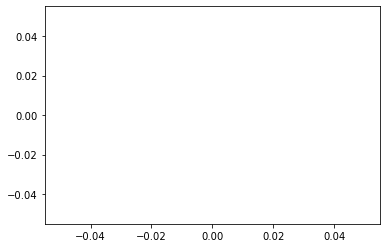

/home/lunet/cvxt2/.conda/envs/torch_hipims/lib/python3.7/site-packages/ipykernel_launcher.py:152: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


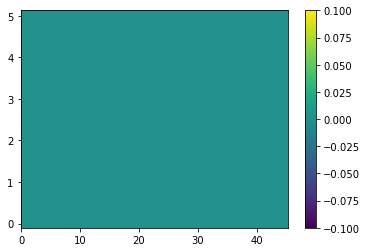

In [1]:
from numpy.lib.npyio import savetxt
import torch
import math
import sys
import os
import numpy as np
import time
import matplotlib.pyplot as plt

from SWE_CUDA import Godunov

cell_size = 0.2012
paraDict = {'deviceID': 0,
            'dx': float(cell_size),
            'CFL': 0.5,
            'Export_timeStep': 100,
            't': 0.0,
            'export_n': 0,
            'secondOrder': False,
            'firstTimeStep': 0.001,
            'tensorType': torch.float64,
            'EndTime': 100,
        }

OUTPUT_PATH = '/home/lunet/cvxt2/hipims_hybrid-master/BackCase'

# ===============================================
# set the device
# ===============================================
torch.cuda.set_device(paraDict['deviceID'])
device = torch.device("cuda", paraDict['deviceID'])

# ===============================================
# set the tensors
# ===============================================

# prepare the dem
tensorsize = [25+2, 225+2]

z = torch.zeros(tensorsize, device=device)
h = torch.zeros(tensorsize, device=device)
qx = torch.zeros(tensorsize, device=device) 
qy = torch.zeros(tensorsize, device=device)
wl = torch.zeros(tensorsize, device=device)
wl = z + h

# set mask
mask = torch.ones(tensorsize, device=device) * 10

# wall non-slip
mask[1,:] = 30
mask[-2,:] = 30
# mask[10, 1:500] = 30
# mask[10:25, 500] = 30
# upstream and downstream
mask[:,1] = 60
mask[:,-2] = 50

# mask[11:26, 1:500] = -9999

# outline
mask[0,:] = -9999
mask[-1,:] = -9999
mask[:,0] = -9999
mask[:,-1] = -9999
print(mask)

rainfall_station_Mask = torch.zeros(tensorsize, device=device)

row = torch.arange(tensorsize[0])
col = torch.arange(tensorsize[1])
y, x = torch.meshgrid(row, col)
x, y = x.type(torch.DoubleTensor), y.type(torch.DoubleTensor)
x = (x - 0.5) * cell_size
y = (y - 0.5) * cell_size
x = x.numpy()
y = y.numpy()

landuse = torch.zeros(tensorsize, device=device)
Manning = 0.01

# ===============================================
# rainfall data
# ===============================================

gauge_index_1D = torch.tensor([])

gauge_index_1D = gauge_index_1D.to(device)

rainfallMatrix = np.array([[0., 0.0], [200., 0.0]])

# ===============================================
# H_GIVEN & Q_GIVEN data
# ===============================================
given_depth = torch.tensor([[0.0, 0.242], [600, 0.242]], dtype=torch.float64, device=device)
given_discharge = torch.tensor([[0.0, 0.202, 0.0], [600, 0.202, 0.0]], dtype=torch.float64, device=device)

# ===============================================
# set field data
# ===============================================
numerical = Godunov(device,
                    paraDict['dx'],
                    paraDict['CFL'],
                    paraDict['Export_timeStep'],
                    t=paraDict['t'],
                    export_n=paraDict['export_n'],
                    firstTimeStep=paraDict['firstTimeStep'],
                    secondOrder=paraDict['secondOrder'],
                    tensorType=paraDict['tensorType'])

numerical.setOutPutPath(OUTPUT_PATH)
numerical.init__fluidField_tensor(mask, h, qx, qy, wl, z, device)
numerical.set__frictionField_tensor(Manning, device)
numerical.set_boundary_tensor(given_depth, given_discharge)
numerical.set_landuse(mask, landuse, device)

# ======================================================================
numerical.set_distributed_rainfall_station_Mask(mask, rainfall_station_Mask,
                                                    device)
# ======================================================================

torch.cuda.empty_cache()

simulation_start = time.time()

index_mask = torch.zeros_like(mask, dtype=torch.int32,
                                      device=device)
index_mask = torch.tensor(
    [i for i in range((mask.flatten()).size()[0])],
    dtype=torch.int32,
    device=device,
)

hh = torch.zeros(tensorsize, dtype=torch.float64, device=device) 
qxx = torch.zeros(tensorsize, dtype=torch.float64, device=device) 
qyy = torch.zeros(tensorsize, dtype=torch.float64, device=device) 

while numerical.t.item() < 8:
    # numerical.addFlux()
    numerical.addStation_PrecipitationSource(rainfallMatrix, device)
    numerical.time_friction_euler_update_cuda(device)
    
hh[mask>0] = numerical.get_h()
qxx[mask>0] = numerical.get_qx()
qyy[mask>0] = numerical.get_qy()

q_x = qxx.cpu().numpy()
q_y = qyy.cpu().numpy()
plt.streamplot(x, y, q_x, q_y, density = 0.5)
plt.show()

plt.pcolor(x, y, hh.cpu().numpy())
plt.colorbar()
plt.show()



In [ ]:
print(q_x[:,10])